# ARIMA Models in Python

Have you ever tried to predict the future? What lies ahead is a mystery which is usually only solved by waiting. In this course, we will stop waiting and learn to use the powerful ARIMA class models to forecast the future. We will learn how to use the statsmodels package to analyze time series, to build tailored models, and to forecast under uncertainty. How will the stock market move in the next 24 hours? How will the levels of CO2 change in the next decade? How many earthquakes will there be next year? We will learn to solve all these problems and more.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import augmented dicky-fuller test function
from statsmodels.tsa.stattools import adfuller
# Import data generation function and set random seed
from statsmodels.tsa.arima_process import arma_generate_sample
# Import the ARIMA model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima as pm

## 1. ARMA Models

Dive straight in and learn about the most important properties of time series. We'll learn about stationarity and how this is important for ARMA models. We'll learn how to test for stationarity by eye and with a standard statistical test. Finally, we'll learn the basic structure of ARMA models and use this to generate some ARMA data and fit an ARMA model.

#### Intro to time series and stationarity

We may make plots regularly, but in this course, it is important that we can explicitly control which axis different time series are plotted on. This will be important so we can evaluate your time series predictions later.

Here our task is to plot a dataset of monthly US candy production between 1972 and 2018.

Specifically, we are plotting the industrial production index IPG3113N. This is total amount of sugar and confectionery products produced in the USA per month, as a percentage of the January 2012 production. So 120 would be 120% of the January 2012 industrial production.

We will check out how this quantity has changed over time and how it changes throughout the year.

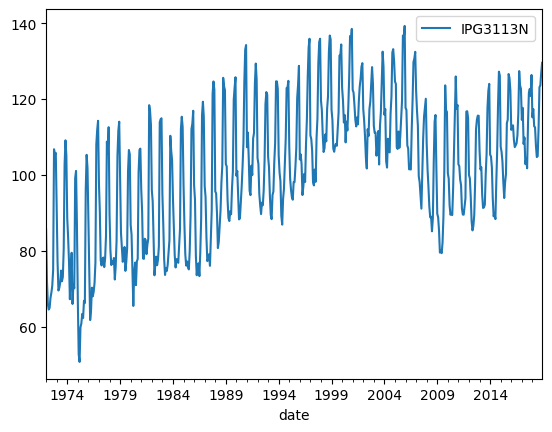

In [2]:
# Load in the time series
candy = pd.read_csv('data_3/candy_production.csv', 
            index_col='date',
            parse_dates=True)

# Plot and show the time series on axis ax1
fig, ax1 = plt.subplots()
candy.plot(ax=ax1)
plt.show()

Next, we are going to take the candy production dataset and split it into a train and a test set.

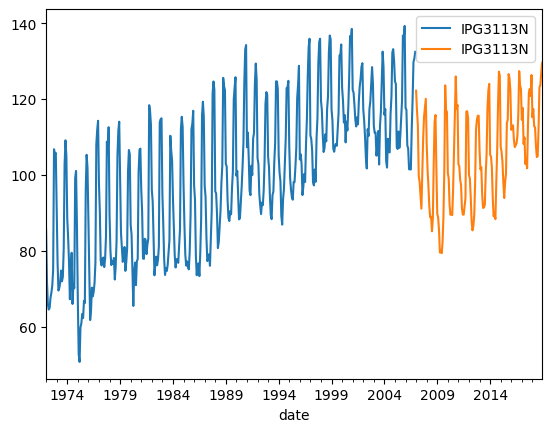

In [3]:
# Split the data into a train and test set
candy_train = candy.loc[:'2006']
candy_test = candy.loc['2007':]

# Create an axis
fig, ax = plt.subplots()

# Plot the train and test sets on the axis ax
candy_train.plot(ax=ax)
candy_test.plot(ax=ax)
plt.show()

#### Making time series stationary

In this exercise we will run the augmented Dicky-Fuller test on the earthquakes time series to test for stationarity.

Remember that if it is not stationary this would mean that the number of earthquakes per year has a trend and is changing (Dicky-Fuller test null hypothesis ☛ time series is non-stationary with a trend). This would be terrible news if it is trending upwards, as it means more damage. It would also be terrible news if it were trending downwards, it might suggest the core of our planet is changing and this could have lots of knock on effects for us!

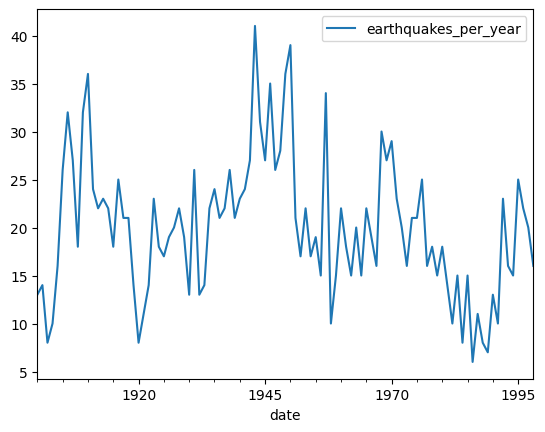

In [4]:
# Load in the time series
earthquake = pd.read_csv('data_3/earthquakes.csv', index_col='date', parse_dates=True)

earthquake.drop('Year', inplace=True, axis=1)

# Plot and show the time series on axis ax1
fig, ax1 = plt.subplots()
earthquake.plot(ax=ax1)
plt.show()

In [5]:
# Run test
result = adfuller(earthquake['earthquakes_per_year'])

# Print test statistic
print(result[0])

# Print p-value
print(result[1])

# Print critical values
print(result[4]) 

-3.183192251191782
0.02097842525600371
{'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}


We can reject the null hypothesis that the time series is non-stationary. Therefore it is stationary. We probably could have intuited this from looking at the graph or by knowing a little about geology. The time series covers only about 100 years which is a very short time on a geological time scale.

__NOTE:__ It is a good practice to test for stationarity by eye and use the Augmented Dicky-Fuller test, and if it is not stationary, take the difference to make the dataset stationary.

Differencing should be the first transform we try to make a time series stationary. But sometimes it isn't the best option.

A classic way of transforming stock time series is the log-return of the series. This is calculated as follows:

$$ log\_return(y_t) = \log \left( \frac{y_t}{y_{t-1}} \right) $$ 

For this exercise, we will use the Amazon stock time series, `amazon`. You can calculate the log-return of this DataFrame by substituting:

- $y_t \rightarrow $ `amazon`
- $y_{t-1} \rightarrow $ `amazon.shift(1)`
- $\log() \rightarrow $ `np.log()`

In this exercise we will compare the log-return transform and the first order difference of the Amazon stock time series to find which is better for making the time series stationary.

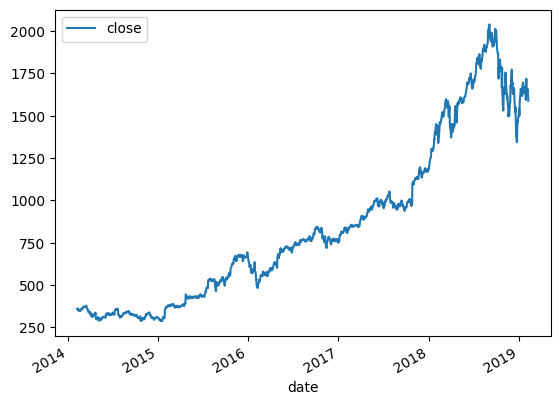

In [6]:
# Load in the time series
amazon = pd.read_csv('data_3/amazon_close.csv', index_col='date', parse_dates=True)

# Plot and show the time series on axis ax1
fig, ax1 = plt.subplots()
amazon.plot(ax=ax1)
plt.show()

In [7]:
# Calculate the first difference and drop the nans
amazon_diff = amazon.diff()
amazon_diff = amazon_diff.dropna()

# Run test and print
result_diff = adfuller(amazon_diff['close'])
print(result_diff)

# Calculate log-return and drop nans
amazon_log = np.log(amazon / amazon.shift(1))
amazon_log = amazon_log.dropna()

# Run test and print
result_log = adfuller(amazon_log['close'])
print(result_log)

(-7.203579488811238, 2.3312717254872737e-10, 23, 1234, {'1%': -3.435660336370594, '5%': -2.863885022214541, '10%': -2.568018522153254}, 10764.626718933836)
(-34.91574853605969, 0.0, 0, 1257, {'1%': -3.4355629707955395, '5%': -2.863842063387667, '10%': -2.567995644141416}, -6245.723147672197)


Notice that both the differenced and the log-return transformed time series have a small p-value, but the log transformed time series has a much more negative test statistic. This means the log-return tranformation is better.

#### Intro to AR, MA and ARMA models

When fitting and working with AR, MA and ARMA models it is very important to understand the model order. We will need to pick the model order when fitting. Picking this correctly will give us a better fitting model which makes better predictions.

In this exercise we will generate 100 days worth of AR/MA/ARMA data. Remember that in the real world applications, this data could be changes in Google stock prices, the energy requirements of New York City, or the number of cases of flu.

We can use the `arma_generate_sample()` function to generate time series using different AR and MA coefficients.

Remember for any model ARMA(p,q):
- The list `ar_coefs` has the form `[1, -a_1, -a_2, ..., -a_p]`.
- The list `ma_coefs` has the form `[1, m_1, m_2, ..., m_q]`,

where `a_i` are the lag-i AR coefficients and `m_j` are the lag-j MA coefficient.

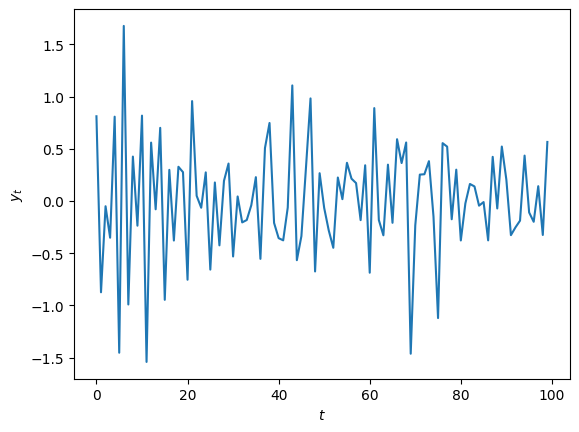

In [8]:
# Set ar_coefs and ma_coefs for an MA(1) model with MA lag-1 coefficient of -0.7.
np.random.seed(1)

# Set coefficients
ar_coefs = [1]
ma_coefs = [1, -0.7]

# Generate data
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=100, scale=0.5)

plt.plot(y)
plt.ylabel(r'$y_t$')
plt.xlabel(r'$t$')
plt.show()

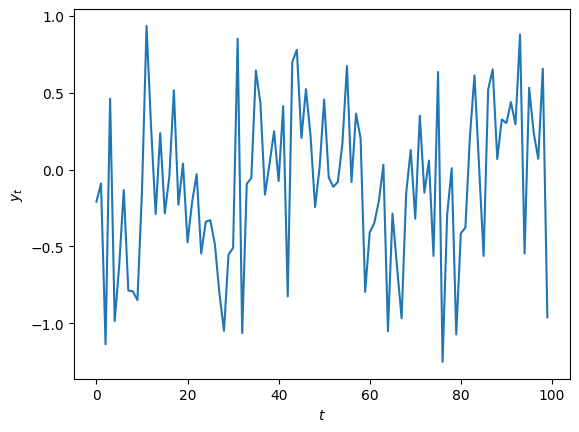

In [9]:
# Set the coefficients for an AR(2) model with AR lag-1 and lag-2 coefficients of 0.3 and 0.2 respectively.
np.random.seed(2)

# Set coefficients
ar_coefs = [1, -0.3, -0.2]
ma_coefs = [1]

# Generate data
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=100, scale=0.5)

plt.plot(y)
plt.ylabel(r'$y_t$')
plt.xlabel(r'$t$')
plt.show()

Set the coefficients for a model with form $ y_t = -0.2y_{t-1} + 0.3 \epsilon_{t-1} + 0.4 \epsilon_{t-2} +  \epsilon_t$.

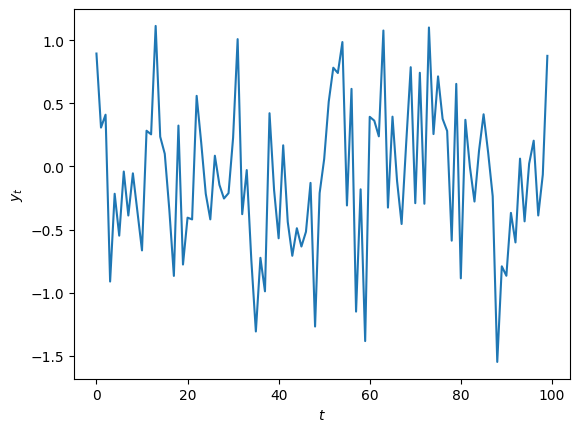

In [10]:
np.random.seed(3)

# Set coefficients
ar_coefs = [1, 0.2]
ma_coefs = [1, 0.3, 0.4]

# Generate data
y = arma_generate_sample(ar_coefs, ma_coefs, nsample=100, scale=0.5)

plt.plot(y)
plt.ylabel(r'$y_t$')
plt.xlabel(r'$t$')
plt.show()

Understanding the order is important when it comes to fitting models. We will always need to select the order of model we fit to your data, no matter what that data is.

In this exercise we will do some basic fitting. Fitting models is the next key step towards making predictions. We'll go into this more in the next chapter but let's get a head start.

We will use data from above to fit ARMA(1,2).

In [11]:
# Instantiate the model
model = ARIMA(y, order=(1,0,2))

# Fit the model
results = model.fit()

# print results
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 -78.440
Date:                Mon, 22 May 2023   AIC                            166.881
Time:                        14:21:36   BIC                            179.907
Sample:                             0   HQIC                           172.153
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0700      0.082     -0.856      0.392      -0.230       0.090
ar.L1         -0.1231      0.228     -0.539      0.590      -0.571       0.324
ma.L1          0.2887      0.190      1.523      0.1

We just fit our first ARIMA model. An ARIMA(1,0,2) model is the exact same as an ARMA(1,2) model, so this was the correct model order for this data. We'll cover this in more detail in the next chapter.

## 2. Fitting the Future

What lies ahead in this chapter is us predicting what lies ahead in our data. We'll learn how to use the elegant statsmodels package to fit ARMA, ARIMA and ARMAX models. Then we'll use our models to predict the uncertain future of stock prices!

#### Fitting time series models

In this exercise we will fit an AR and an MA model to some data. We wiil generated data using the `arma_generate_sample()` function we used before.

We know the real AR and MA parameters used to create this data so it is a really good way to gain some confidence with ARMA models and know we are doing it right. In the next exercise we'll move onto some real world data with confidence.

In [12]:
# Set coefficients
ar_coefs_1 = [1, -0.9, 0.3]
ma_coefs_1 = [1]

# Generate data
timeseries_1 = arma_generate_sample(ar_coefs_1, ma_coefs_1, nsample=1000, scale=0.5)


# Set coefficients
ar_coefs_2 = [1]
ma_coefs_2 = [1, 0.2, 0.6, -0.1]

# Generate data
timeseries_2 = arma_generate_sample(ar_coefs_2, ma_coefs_2, nsample=1000, scale=0.5)

In [13]:
# Instantiate the model
model = ARIMA(timeseries_1, order=(2,0,0))

# Fit the model
results = model.fit()

# Print summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -736.886
Date:                Mon, 22 May 2023   AIC                           1481.771
Time:                        14:21:36   BIC                           1501.402
Sample:                             0   HQIC                          1489.232
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0237      0.037      0.641      0.522      -0.049       0.096
ar.L1          0.8661      0.031     27.788      0.000       0.805       0.927
ar.L2         -0.2992      0.030     -9.910      0.0

In [14]:
# Instantiate the model
model = ARIMA(timeseries_2, order=(0,0,3))

# Fit the model
results = model.fit()

# Print summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 3)   Log Likelihood                -726.991
Date:                Mon, 22 May 2023   AIC                           1463.982
Time:                        14:21:36   BIC                           1488.521
Sample:                             0   HQIC                          1473.309
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0585      0.026     -2.247      0.025      -0.110      -0.007
ma.L1          0.1779      0.031      5.690      0.000       0.117       0.239
ma.L2          0.5785      0.026     22.197      0.0

The fitted models had very similar AR and MA coefficient values to the real ones! Now, we know it works!

In this exercise we will fit an ARMA model to the earthquakes dataset. We saw before that the earthquakes dataset is stationary so we don't need to transform it at all. It comes ready for modeling straight out the ground. 

In [15]:
# Instantiate the model
model = ARIMA(earthquake, order=(3,0,1))

# Fit the model
results = model.fit()

# Print model fit summary
print(results.summary())

                                SARIMAX Results                                 
Dep. Variable:     earthquakes_per_year   No. Observations:                   99
Model:                   ARIMA(3, 0, 1)   Log Likelihood                -315.673
Date:                  Mon, 22 May 2023   AIC                            643.345
Time:                          14:21:37   BIC                            658.916
Sample:                      01-01-1900   HQIC                           649.645
                           - 01-01-1998                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.6453      2.233      8.798      0.000      15.269      24.022
ar.L1          0.5795      0.645      0.899      0.369      -0.684       1.843
ar.L2          0.0251      0.308    

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In this exercise we will fit an ARMAX model to a time series which represents the wait times at an accident and emergency room for urgent medical care.

The variable we would like to model is the wait times to be seen by a medical professional `wait_times_hrs`. This may be related to an exogenous variable that we measured `nurse_count` which is the number of nurses on shift at any given time.

The data was downloded from the following repository [link](https://github.com/goodboychan/goodboychan.github.io/tree/main/_notebooks/dataset).

This is a particularly interesting case of time series modeling as, if the number of nurses has an effect, we could change this to affect the wait times.

In [16]:
hospital = pd.read_csv('./data_3/hospital.csv', index_col=0, parse_dates=True)
hospital.head()

,wait_times_hrs,nurse_count
2019-03-04 00:00:00,1.747261,1.0
2019-03-04 01:00:00,1.664634,1.0
2019-03-04 02:00:00,1.647047,1.0
2019-03-04 03:00:00,1.619512,1.0
2019-03-04 04:00:00,1.480415,1.0


array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

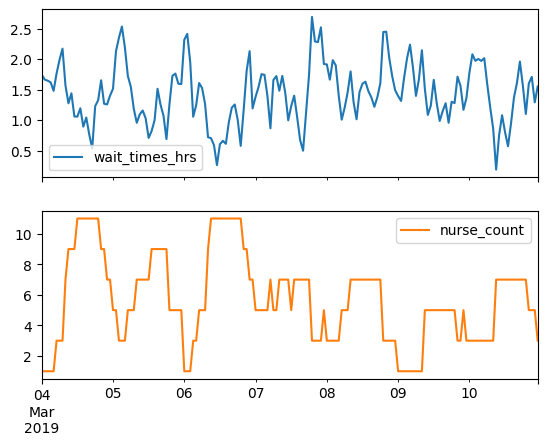

In [17]:
hospital.plot(subplots=True)

In [18]:
# Instantiate the model
model = ARIMA(hospital['wait_times_hrs'], order=(2,0,1), exog=hospital['nurse_count'])

# Fit the model
results = model.fit()

# Print model fit summary
print(results.summary())

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         wait_times_hrs   No. Observations:                  168
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -11.834
Date:                Mon, 22 May 2023   AIC                             35.668
Time:                        14:21:37   BIC                             54.411
Sample:                    03-04-2019   HQIC                            43.275
                         - 03-10-2019                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.1001      0.086     24.375      0.000       1.931       2.269
nurse_count    -0.1171      0.012     -9.562      0.000      -0.141      -0.093
ar.L1           0.5693      0.169      3.365    

Look back at the model parameters. What is the relation between the number of nurses on shift and the wait times? If you predicted that tomorrow was going to have long wait times how could you combat this?

#### Forecasting

It is very hard to forecast stock prices. Classic economics actually tells us that this should be impossible because of market clearing.

Our task in this exercise is to attempt the impossible and predict the Amazon stock price anyway.

In this exercise we will generate one-step-ahead predictions for the stock price as well as the uncertainty of these predictions.

For this exercise we will use model fitting from [link](https://github.com/goodboychan/goodboychan.github.io/blob/main/_notebooks/2020-06-15-02-Fitting-the-Future.ipynb).

In [19]:
amazon.sort_index(inplace=True)
model = SARIMAX(amazon, order=(3, 1, 3), seasonal_order=(1, 0, 1, 7),
                enforce_invertibility=False,
                enforce_stationarity=False,
                simple_differencing=False, 
                measurement_error=False,
                k_trend=0)

results = model.fit()

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               close   No. Observations:                 1259
Model:             SARIMAX(3, 1, 3)x(1, 0, [1], 7)   Log Likelihood               -5487.770
Date:                             Mon, 22 May 2023   AIC                          10993.540
Time:                                     14:21:41   BIC                          11039.697
Sample:                                          0   HQIC                         11010.894
                                            - 1259                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0989      0.018     -5.456      0.000      -0.134      -0.063
ar.L2         -0.1496      0.017     -8.667      0.000      -0.183      -0.116
ar.L3         -0.9553      0.016    -58.147      0.000      -0.988      -0.923
ma.L1          0.0908      0.019      4.851      0.000       0.054       0.127
ma.L2          0.1461      0.022      6.543      0.000       0.102       0.190
ma.L3          1.0160      0.020     50.261      0.000       0.976       1.056
ar.S.L7        0.4339      0.326      1.330      0.183      -0.205       1.073
ma.S.L7       -0.4722      0.318     -1.486      0.137      -1.095       0.151
sigma2       373.0832     13.595     27.442      0.000     346.437     399.730
===================================================================================
Ljung-Box (L1) (Q):                   3.22   Jarque-Bera (JB):              7013.89
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):              14.96   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
# Generate predictions
one_step_forecast = results.get_prediction(start=-30)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower close']
upper_limits = confidence_intervals.loc[:,'upper close']

# Print best estimate  predictions
print(mean_forecast)

date
2018-12-27    1479.816897
2018-12-28    1467.600055
2018-12-31    1472.498122
2019-01-02    1496.488266
2019-01-03    1537.717102
2019-01-04    1506.632328
2019-01-07    1582.349000
2019-01-08    1631.015350
2019-01-09    1648.000936
2019-01-10    1649.979648
2019-01-11    1657.042741
2019-01-14    1651.718792
2019-01-15    1622.263046
2019-01-16    1669.994681
2019-01-17    1672.487581
2019-01-18    1686.818714
2019-01-22    1698.977323
2019-01-23    1641.899784
2019-01-24    1649.074354
2019-01-25    1646.722653
2019-01-28    1659.295797
2019-01-29    1631.150366
2019-01-30    1600.363702
2019-01-31    1684.595607
2019-02-01    1720.188491
2019-02-04    1615.573422
2019-02-05    1624.604854
2019-02-06    1659.622146
2019-02-07    1651.664152
2019-02-08    1616.585365
Name: predicted_mean, dtype: float64


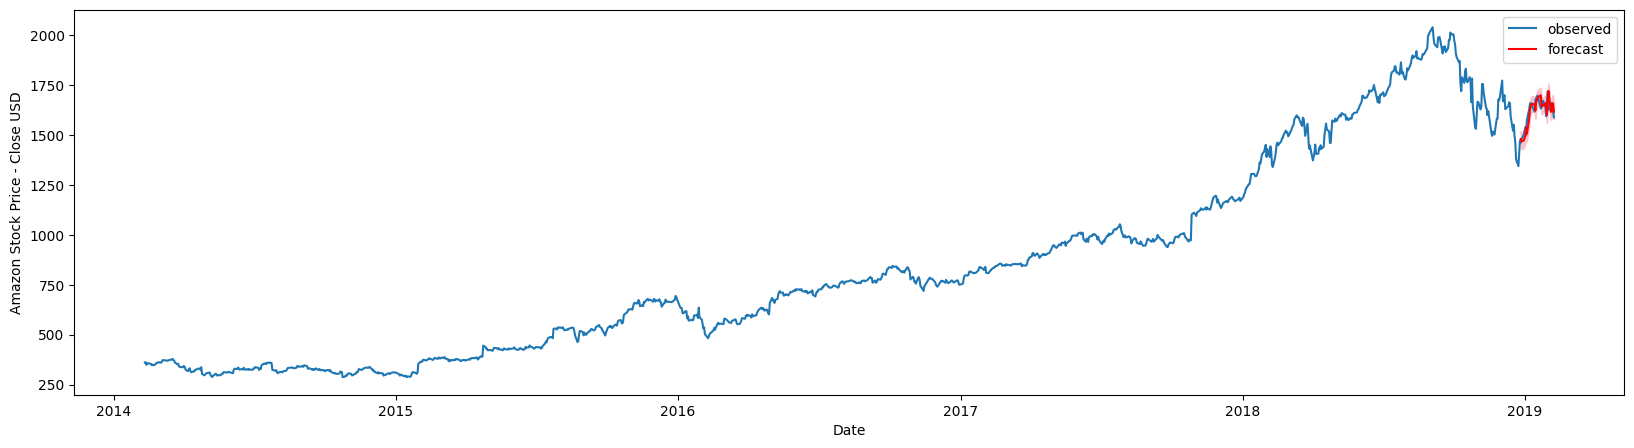

In [22]:
fig, ax = plt.subplots(figsize=(20, 5))

# plot the amazon data
plt.plot(amazon.index, amazon, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits,
		 upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Amazon Stock Price - Close USD')
plt.legend()
plt.show()

Now lets move a little further into the future, to dynamic predictions. What if we wanted to predict the Amazon stock price, not just for tomorrow, but for next week or next month? This is where dynamical predictions come in.

Remember that it is more difficult to make precise long-term forecasts because the shock terms add up. The further into the future the predictions go, the more uncertain. This is especially true with stock data and so we will likely find that our predictions in this exercise are not as precise as those in the last exercise.

In [23]:
# Generate predictions
dynamic_forecast = results.get_prediction(start=-30, dynamic=True)

# Extract prediction mean
mean_forecast = dynamic_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = dynamic_forecast.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower close']
upper_limits = confidence_intervals.loc[:,'upper close']

# Print best estimate predictions
print(mean_forecast)

date
2018-12-27    1479.816897
2018-12-28    1486.100902
2018-12-31    1479.693606
2019-01-02    1474.157251
2019-01-03    1472.867351
2019-01-04    1482.215987
2019-01-07    1486.197486
2019-01-08    1488.521088
2019-01-09    1478.854095
2019-01-10    1473.949191
2019-01-11    1475.086990
2019-01-14    1486.334473
2019-01-15    1490.723219
2019-01-16    1487.270281
2019-01-17    1477.461751
2019-01-18    1474.794475
2019-01-22    1479.081889
2019-01-23    1489.045760
2019-01-24    1490.570763
2019-01-25    1485.261689
2019-01-28    1475.931927
2019-01-29    1476.734767
2019-01-30    1483.139227
2019-01-31    1490.976455
2019-02-01    1488.744974
2019-02-04    1481.937357
2019-02-05    1475.643152
2019-02-06    1479.368619
2019-02-07    1486.680281
2019-02-08    1491.419994
Name: predicted_mean, dtype: float64


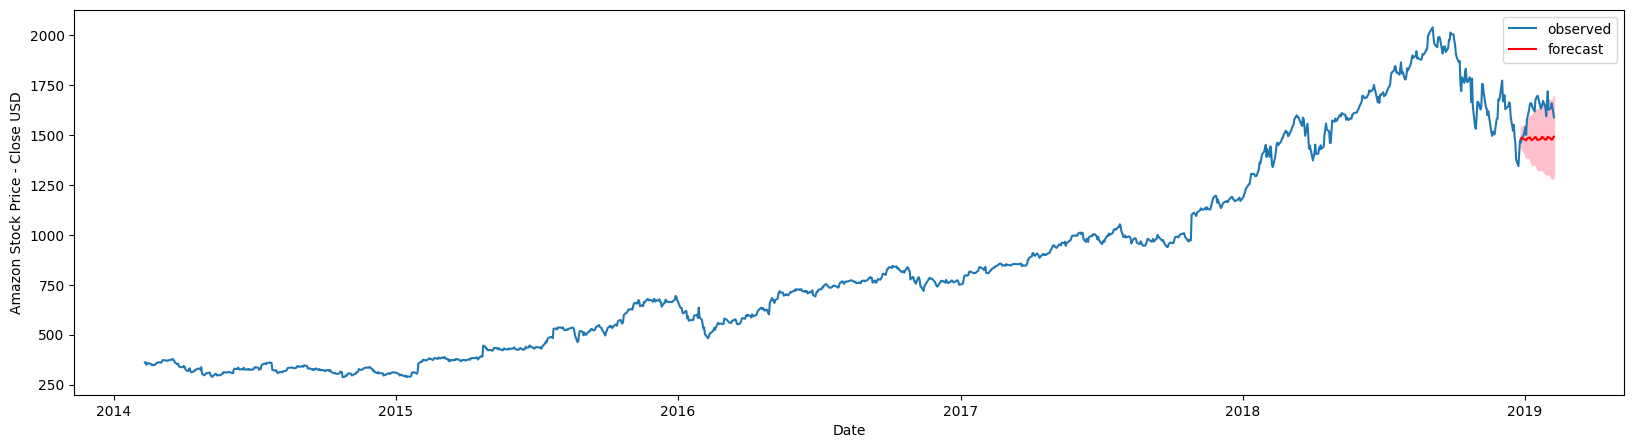

In [24]:
fig, ax = plt.subplots(figsize=(20, 5))
# plot the amazon data
plt.plot(amazon.index, amazon, label='observed')

# plot your mean forecast
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits, 
         upper_limits, color='pink')

# set labels, legends and show plot
plt.xlabel('Date')
plt.ylabel('Amazon Stock Price - Close USD')
plt.legend()
plt.show()

It is very hard to predict stock market performance and so our predictions have a wide uncertainty. However, note that the real stock data stayed within our uncertainty limits!

#### Intro to ARIMA models

In this exercise we will fit an ARMA model to the Amazon stocks dataset. As we saw before, this is a non-stationary dataset. We will use differencing to make it stationary so that we can fit an ARMA model.

In the next section we'll make a forecast of the differences and use this to forecast the actual values.

In [25]:
# Take the first difference of the data
amazon_diff = amazon.diff().dropna()

# Create ARMA(2,2) model
arma = ARIMA(amazon_diff, order=(2,0,2))

# Fit model
arma_results = arma.fit()

# Print fit summary
print(arma_results.summary())

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1258
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -5532.371
Date:                Mon, 22 May 2023   AIC                          11076.743
Time:                        14:21:43   BIC                          11107.566
Sample:                             0   HQIC                         11088.327
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9867      0.494      1.996      0.046       0.018       1.955
ar.L1         -0.1541      0.073     -2.119      0.034      -0.297      -0.012
ar.L2          0.7945      0.072     11.085      0.0

Remember that now we have a model which we can use to predict the difference values, not the absolute value of the `amazon` dataset.

Now we will use the model that we trained in the previous exercise `arma` in order to forecast the absolute value of the Amazon stocks dataset. Remember that sometimes predicting the difference could be enough; will the stocks go up, or down; but sometimes the absolute value is key.

In [26]:
# Make arma forecast of next 10 differences
arma_diff_forecast = arma_results.get_forecast(steps=10).predicted_mean

# Integrate the difference forecast
arma_int_forecast =np.cumsum(arma_diff_forecast)

# Make absolute value forecast
arma_value_forecast = arma_int_forecast + amazon.iloc[-1,0]

# Print forecast
print(arma_value_forecast)

1258    1592.060529
1259    1594.209784
1260    1597.284553
1261    1598.873001
1262    1601.425849
1263    1602.649210
1264    1604.843687
1265    1605.832242
1266    1607.778202
1267    1608.618520
Name: predicted_mean, dtype: float64


C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


We have just made an ARIMA forecast the hard way. Next we'll use statsmodels to make things easier.

In this exercise we'll learn how to be lazy in time series modeling. Instead of taking the difference, modeling the difference and then integrating, we're just going to lets `statsmodels` do the hard work for us.

We'll repeat the same exercise that we did before, of forecasting the absolute values of the Amazon stocks dataset, but this time with an ARIMA model.

In [27]:
# Create ARIMA(2,1,2) model
arima = ARIMA(amazon, order=(2,1,2))

# Fit ARIMA model
arima_results = arima.fit()

# Make ARIMA forecast of next 10 values
arima_value_forecast = arima_results.get_forecast(steps=10).predicted_mean

# Print forecast
print(arima_value_forecast)

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


1259    1593.639455
1260    1601.906411
1261    1605.418925
1262    1600.976727
1263    1592.696654
1264    1588.197619
1265    1591.590210
1266    1599.721277
1267    1605.104189
1268    1602.811957
Name: predicted_mean, dtype: float64


C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


You just made the same forecast you made before, but this time with an ARIMA model. Our two forecasts give almost the same results, but the ARIMA forecast was a lot easier to code!

__NOTE:__ We want to make sure our data is stationary but don't want to over difference it either.

## 3. The Best of the Best Models

In this chapter, we will become a modeler of discerning taste. We'll learn how to identify promising model orders from the data itself, then, once the most promising models have been trained, we'll learn how to choose the best model from this fitted selection. We'll also learn a great framework for structuring our time series projects.

#### Intro to ACF and PACF

In this exercise we will use the ACF and PACF to decide whether some data is best suited to an MA model or an AR model. Remember that selecting the right model order is of great importance to our predictions.

Remember that for different types of models we expect the following behavior in the ACF and PACF:

| | AR(p) | MA(q) | ARMA(p,q) |
| --- | --- | --- | --- |
| ACF | Tails off | Cuts off after lag q | Tails off |
| PACF | Cuts off after lag p | Tails off | Tails off |

In this exercise we will use the ACF and PACF plots to decide on the most appropriate order to forecast the earthquakes time series.

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


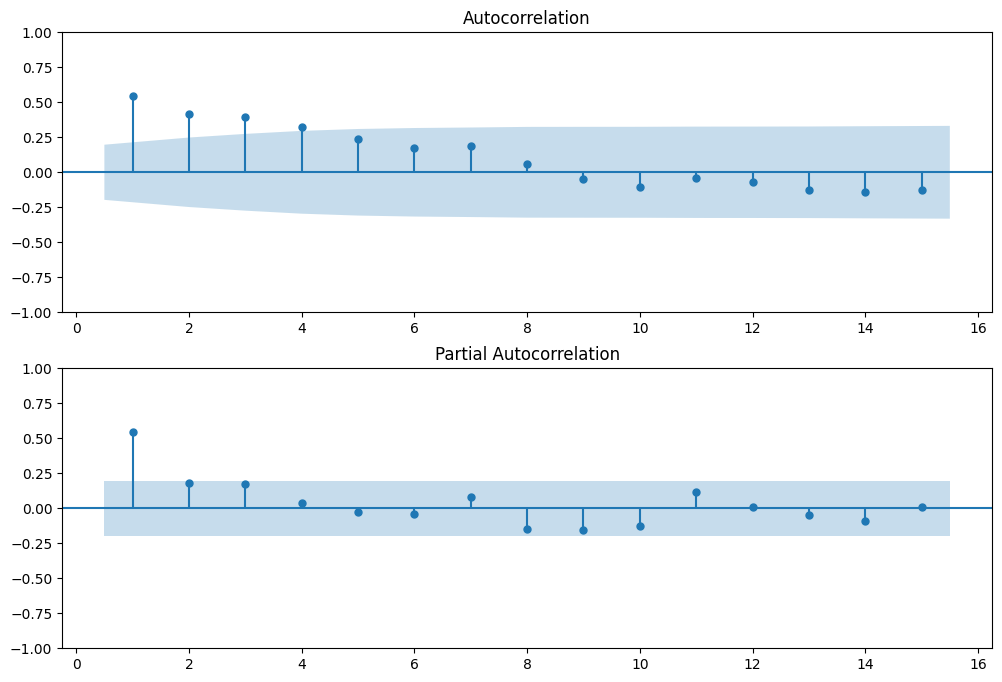

In [28]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot ACF and PACF
plot_acf(earthquake, lags=15, zero=False, ax=ax1)
plot_pacf(earthquake, lags=15, zero=False, ax=ax2)

# Show plot
plt.show()

By looking at the ACF/PACF plots and the table above we can say that __the most appropriate model for the earthquake data is the AR(1).__

__NOTE__: It is not ARMA(1, 4) since the amplitude of both the ACF and PACF would tail off. We don't see that here.

In [29]:
# Instantiate model
model = ARIMA(earthquake, order=(1,0,0))

# Train model
results = model.fit()

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In this exercise we just went the whole way from raw data to the optimal trained model! 

#### AIC and BIC

We can use other criteria the model type and order selection:

__AIC - Akaike information criterion__ 
- Lower AIC indicates a better model
- AIC likes to choose simple models with lower order

__BIC - Bayesian information criterion__ 
- Very similar to AIC
- Lower BIC indicates a better model
- BIC likes to choose simple models with lower order

__AIC vs BIC__
- BIC favors simpler models than AIC
- AIC is better at choosing predictive models
- BIC is better at choosing good explanatory model

In order to choose the best order for model we are going to have to do a search over lots of potential model orders to find the best set.

```
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(3):
  # Loop over q values from 0-2
    for q in range(3):
      	# create and fit ARMA(p,q) model
        model = ARIMA(df, order=(p,0,q))
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p, q, results.aic, results.bic))
        
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

```


In this exercise we will apply an AIC-BIC order search for the earthquakes time series. In the last lesson we decided that this dataset looked like an AR(1) process. We will do a grid search over parameters to see if you get the same results.

In [30]:
earthquake = earthquake.asfreq('AS')
# Loop over p values from 0-2
for p in range(3):
    # Loop over q values from 0-2
    for q in range(3):
      
        try:
            # create and fit ARMA(p,q) model
            model = ARIMA(earthquake, order=(p,0,q))
            results = model.fit()
            
            # Print order and results
            print(p, q, results.aic, results.bic)
            
        except:
            print(p, q, None, None)     

0 0 676.5443594984636 681.7345991987328
0 1 654.8468586200252 662.6322181704289
0 2 651.7332270518992 662.1137064524376
1 0 643.9676770992022 651.753036649606
1 1 640.4562835911977 650.836762991736
1 2 642.3808673565711 655.3564666072441
2 0 642.7338539385339 653.1143333390722


C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 1 647.4406643960186 660.4162636466916
2 2 642.4685896289844 658.039308729792


If you look at our printed results we will see that the AIC and BIC both actually favor an ARMA(1,1) model. This isn't what we predicted from the ACF and PACF but notice that the lag 2-3 PACF values are very close to significant, so the ACF/PACF are close to those of an ARMA(p,q) model.

#### Model diagnostics

Obviously, before we use the model to predict, we want to know how accurate your predictions are. The mean absolute error (MAE) is a good statistic for this. It is the mean difference between our predictions and the true values.

In this exercise we will calculate the MAE for an ARMA(1,1) model fit to the earthquakes time series.

4.56898829488138


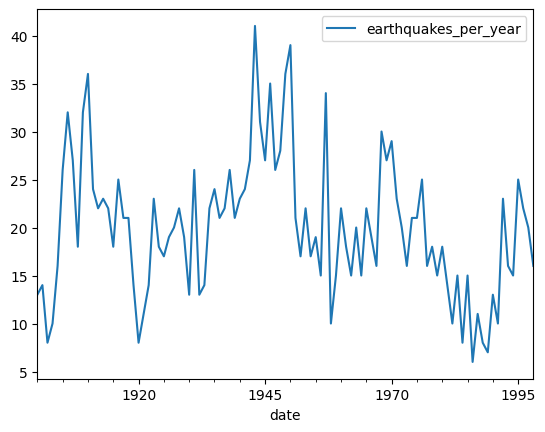

In [31]:
# Fit model
model = ARIMA(earthquake, order=(1,0,1))
results = model.fit()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))

# Print mean absolute error
print(mae)

# Make plot of time series for comparison
earthquake.plot()
plt.show()

Our mean error is about 4-5 earthquakes per year. We have plotted the time series so that we can see how the MAE compares to the spread of the time series. Considering that there are about 20 earthquakes per year that is not too bad.

It is important to know when we need to go back to the drawing board in model design. We can use the residual test statistics in the results summary to decide whether a model is a good fit to a time series.

Here is a reminder of the tests in the model summary:

| Test | Null hypothesis | P-value name |
| --- | --- | --- |
| Ljung-Box | There are no correlations in the residual | Prob(Q) |
| Jarque-Bera | The residuals are normally distributed | Prob(JB) |

If the values of Prob(Q) and Prob(JB) are less then 0.05, it means that the model has a "poor" quality.

In [32]:
# Print summary
print(results.summary())

                                SARIMAX Results                                 
Dep. Variable:     earthquakes_per_year   No. Observations:                   99
Model:                   ARIMA(1, 0, 1)   Log Likelihood                -316.228
Date:                  Mon, 22 May 2023   AIC                            640.456
Time:                          14:21:46   BIC                            650.837
Sample:                      01-01-1900   HQIC                           644.656
                           - 01-01-1998                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.6684      2.137      9.202      0.000      15.479      23.858
ar.L1          0.8306      0.084      9.881      0.000       0.666       0.995
ma.L1         -0.4369      0.140    

We can also use 4 common plots to decide whether a model is a good fit to some data.

Here is a reminder of what we would like to see in each of the plots for a model that fits well:

| Test | Good fit |
| --- | --- |
| Standardized residual | There are no obvious patterns in the residuals |
| Histogram plus kde estimate | The KDE curve should be very similar to the normal distribution |
| Normal Q-Q | Most of the data points should lie on the straight line |
| Correlogram | 95% of correlations for lag greater than zero should not be significant |

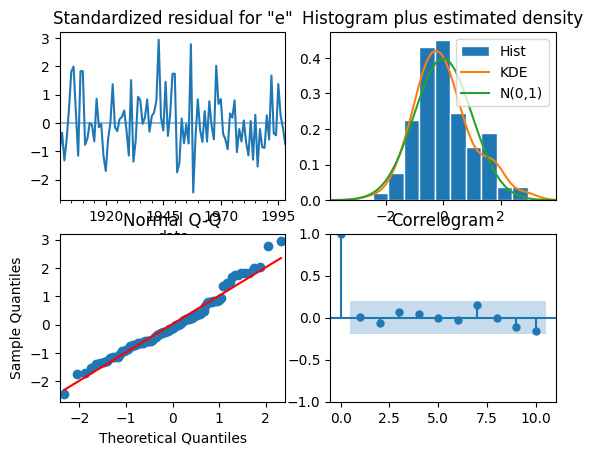

In [33]:
# Create the 4 diagostics plots
results.plot_diagnostics()
plt.show()

#### Box-Jenkins method

In the following exercises we will apply to the Box-Jenkins methodology to go from an unknown dataset to a model which is ready to make forecasts. 

We will be using a new time series. This is the personal savings as % of disposable income 1955-1979 in the US.
The first step of the Box-Jenkins methodology is __Identification__. In this exercise we will use the tools at our disposal to test whether this new time series is stationary.

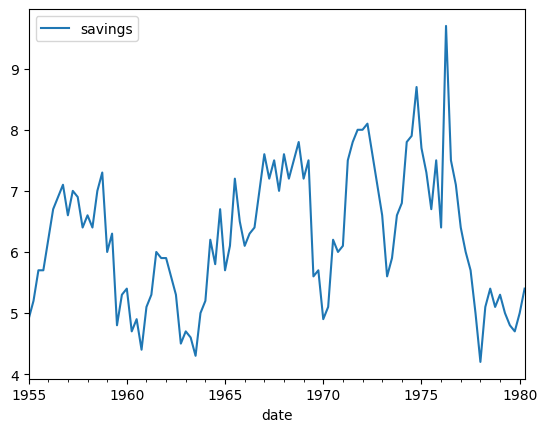

(-3.185899096242141, 0.020815541644114092, 2, 99, {'1%': -3.498198082189098, '5%': -2.891208211860468, '10%': -2.5825959973472097}, 188.1686662239687)
0.020815541644114092


In [34]:
# Load in the time series
savings = pd.read_csv('data_3/savings.csv', 
            index_col='date',
            parse_dates=True)

savings = savings.asfreq(freq = 'QS')


# Plot and show the time series on axis ax1
fig, ax1 = plt.subplots()
savings.plot(ax=ax1)
plt.show()


# Run Dicky-Fuller test
result = adfuller(savings['savings'])

# Print test statistic
print(result)

# Print p-value
print(result[1])

The Dicky-Fuller test says that the series is stationary. We can confirm this when we look at the plot. There is one fairly high value is 1976 which might be anomalous, but we will leave that for now.

We learned that the `savings` time series is stationary without differencing. Now that we have this information we can try and identify what order of model will be the best fit.

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


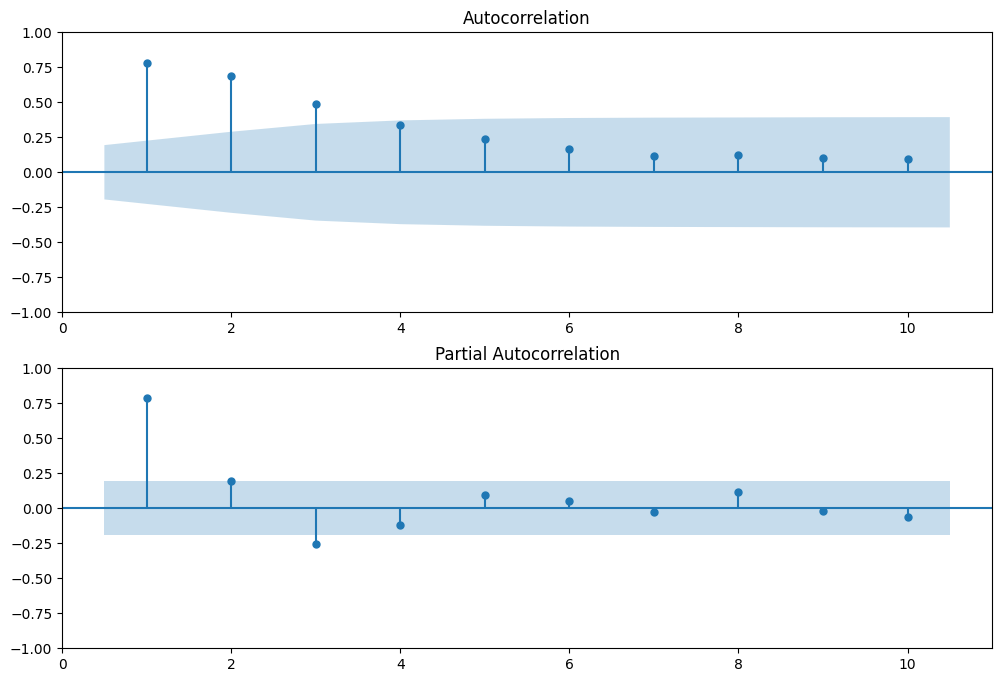

In [35]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
 
# Plot the ACF of savings on ax1
plot_acf(savings, lags=10, zero=False, ax=ax1)

# Plot the PACF of savings on ax2
plot_pacf(savings, lags=10, zero=False, ax=ax2)

plt.show()

Step one complete! The ACF and the PACF are a little inconclusive for this ones. The ACF tails off nicely but the PACF might be tailing off or it might be dropping off. So it could be an ARMA(p,q) model or a AR(p) model.

The results suggest our data could be an ARMA(p,q) model or could be an imperfect AR(3) model. In this exercise we will search over models over some model orders to find the best one according to AIC.

In [36]:
# Loop over p values from 0-3
for p in range(4):
  
  # Loop over q values from 0-3
    for q in range(4):
      try:
        # Create and fit ARMA(p,q) model
        model = ARIMA(savings, order=(p,0,q))
        results = model.fit()
        
        # Print p, q, AIC, BIC
        print(p, q, results.aic, results.bic)
        
      except:
        print(p, q, None, None)

0 0 313.6028657381061 318.85281136467466
0 1 267.06970980844704 274.94462824829986
0 2 232.167826773638 242.6677180267751
0 3 217.59720509753333 230.7220691639547
1 0 216.203479563773 224.0783980036258
1 1 215.7003889529165 226.2002802060536
1 2 207.65298384447473 220.77784791089607
1 3 209.57498315813814 225.32482003784378
2 0 213.97232199692382 224.47221325006092
2 1 213.4303586787603 226.55522274518165


C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2 2 209.57903144324058 225.32886832294622


C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2 3 211.57498195129355 229.94979164428344
3 0 209.5449293671732 222.66979343359458
3 1 210.82147284903127 226.57130972873688
3 2 211.4575954849681 229.83240517795798


C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


3 3 213.35650857574822 234.35629108202238


Step two complete! We didn't store and sort our results this time. But the AIC and BIC both picked the ARMA(1,2) model as the best and the AR(3) model as the second best.

We have arrived at the model __diagnostic stage__. So far we have found that the initial time series was stationary, but may have one outlying point. We identified promising model orders using the ACF and PACF and confirmed these insights by training a lot of models and using the AIC and BIC.

We found that the ARMA(1,2) model was the best fit to our data and now we want to check over the predictions it makes before we would move it into production.

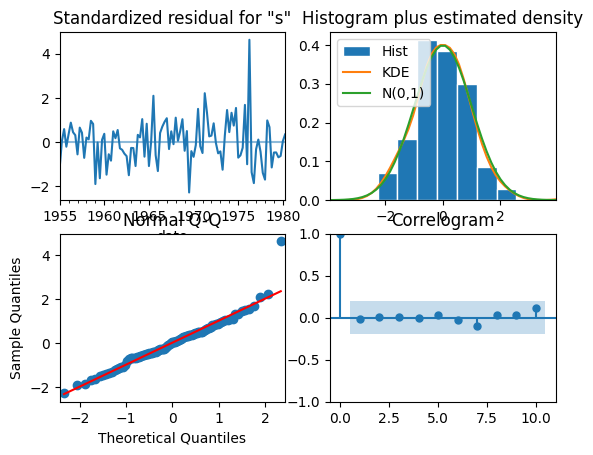

                               SARIMAX Results                                
Dep. Variable:                savings   No. Observations:                  102
Model:                 ARIMA(1, 0, 2)   Log Likelihood                 -98.826
Date:                Mon, 22 May 2023   AIC                            207.653
Time:                        14:21:50   BIC                            220.778
Sample:                    01-01-1955   HQIC                           212.968
                         - 04-01-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1949      0.323     19.169      0.000       5.561       6.828
ar.L1          0.7284      0.111      6.534      0.000       0.510       0.947
ma.L1         -0.0538      0.145     -0.370      0.7

In [37]:
# Create and fit model
model = ARIMA(savings, order=(1,0,2))
results = model.fit()

# Create the 4 diagostics plots
results.plot_diagnostics()
plt.show()

# Print summary
print(results.summary())

The JB p-value is zero, which means we should __reject__ the null hypothesis that the residuals are normally distributed. However, the histogram and Q-Q plots show that the residuals look normal. __This time the JB value was thrown off by the one outlying point in the time series__. In this case, we could go back and apply some transformation to remove this outlier or you probably just continue to the production stage.

## 4. Seasonal ARIMA Models

In this final chapter, we'll learn how to use seasonal ARIMA models to fit more complex data. We'll learn how to decompose this data into seasonal and non-seasonal parts and then we'll get the chance to utilize all our ARIMA tools on one last global forecast challenge.

#### Seasonal time series

We can think of a time series as being composed of trend, seasonal and residual components. This can be a good way to think about the data when we go about modeling it. If we know the period of the time series we can decompose it into these components.

In this exercise we will decompose a time series showing the monthly milk production per cow in the USA. This will give us a clearer picture of the trend and the seasonal cycle. Since the data is monthly we will guess that the seasonality might be 12 time periods, however this won't always be the case.

In [38]:
milk_production = pd.read_csv('data_3/milk_production.csv', 
                              index_col='date',
                              parse_dates=True)

milk_production = milk_production.asfreq(freq = 'MS')

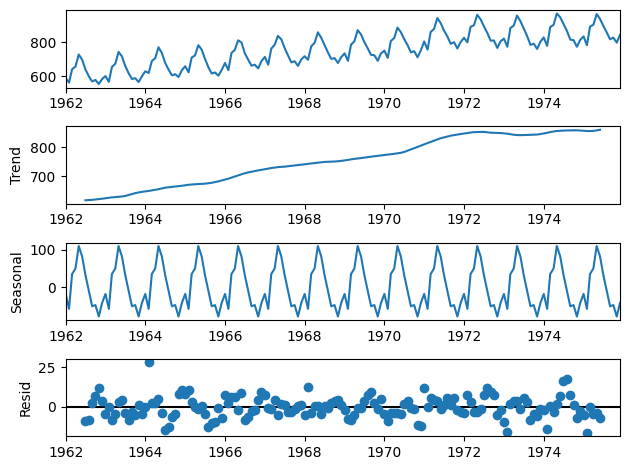

In [39]:
# Perform additive decomposition
decomp = seasonal_decompose(milk_production, 
                            period=12)

# Plot decomposition
decomp.plot()
plt.show()

We have extracted the seasonal cycle and now you can see the trend much more clearly.

Below is a time series showing the estimated number of water consumers in London. By eye we can't see any obvious seasonal pattern, however our eyes aren't the best tools you have. 

In this exercise we will use the ACF and PACF to test this data for seasonality. We can see from the plot below that the time series isn't stationary, so we should probably detrend it. We will detrend it by subtracting the moving average. Remember that we could use a window size of any value bigger than the likely period.

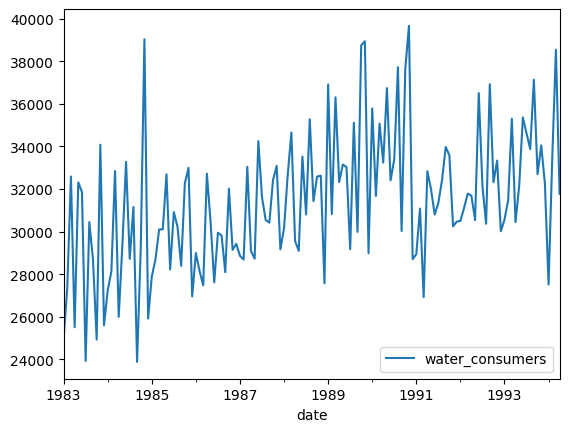

In [40]:
water = pd.read_csv('data_3/water.csv', 
                    index_col='date',
                    parse_dates=True)

water = water.asfreq(freq = 'MS')

water.plot()
plt.show()

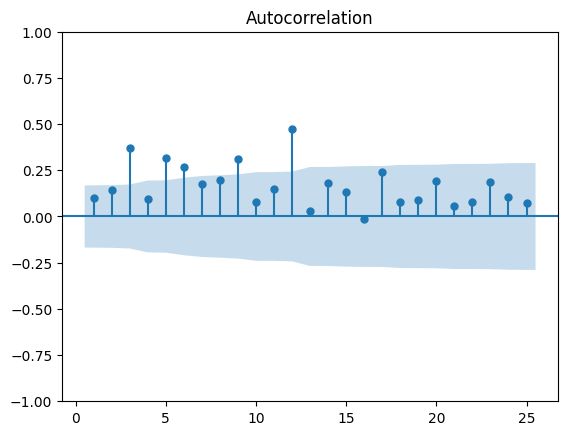

In [41]:
# Create figure and subplot
fig, ax1 = plt.subplots()

# Plot the ACF on ax1
plot_acf(water['water_consumers'], lags=25, zero=False,  ax=ax1)

# Show figure
plt.show()

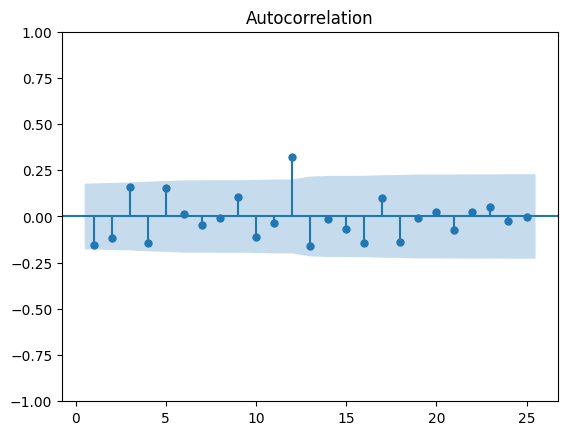

In [42]:
# Subtract the rolling mean
water_2 = water - water.rolling(15).mean()

# Drop the NaN values
water_2 = water_2.dropna()

# Create figure and subplots
fig, ax1 = plt.subplots()

# Plot the ACF
plot_acf(water_2['water_consumers'], lags=25, zero=False, ax=ax1)

# Show figure
plt.show()

The time period of the seasonal component of this data is 12 time steps. Although we couldn't see it by looking at the time series itself, the ACF shows that there is an seasonal component and so including it will make our predictions better.

#### SARIMA models

Fitting SARIMA models is the beginning of the end of this journey into time series modeling.

It is important that we get to know our way around the SARIMA model orders and so that's what we will focus on here.

In this exercise we will find the appropriate model order for a new set of time series. This is monthly series of the number of employed persons in Australia (in thousands). The seasonal period of this time series is 12 months.

| | AR(p) | MA(q) | ARMA(p,q) |
| --- | --- | --- | --- |
| ACF | Tails off | Cuts off after lag q | Tails off |
| PACF | Cuts off after lag p | Tails off | Tails off |



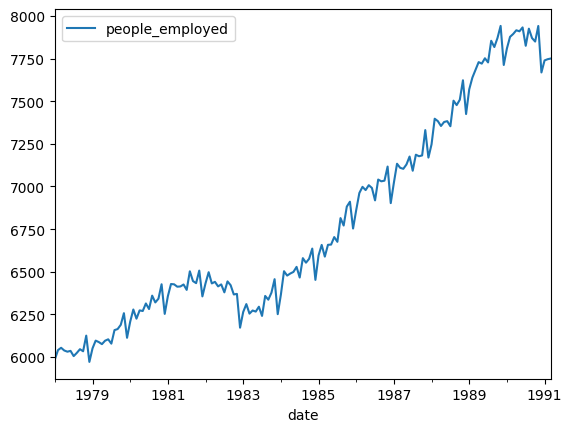

In [43]:
aus_employment = pd.read_csv('data_3/aus_employment.csv', 
                             index_col='date',
                             parse_dates=True)

aus_employment = aus_employment.asfreq(freq = 'MS')

aus_employment.plot()
plt.show()

C:\Users\DmitriGazizulin\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


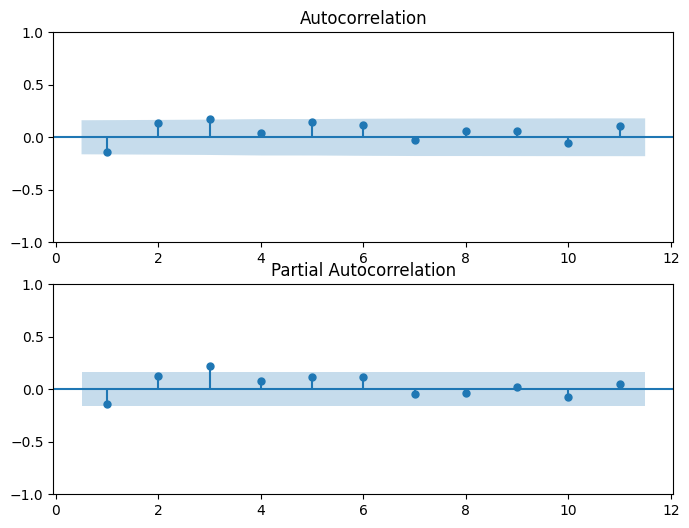

In [44]:
# Take the first and seasonal differences and drop NaNs
aus_employment_diff = aus_employment.diff().diff(12).dropna()

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

# Plot the ACF on ax1
plot_acf(aus_employment_diff, lags=11, ax=ax1, zero=False)

# Plot the PACF on ax2
plot_pacf(aus_employment_diff, lags=11, ax=ax2, zero=False)

plt.show()

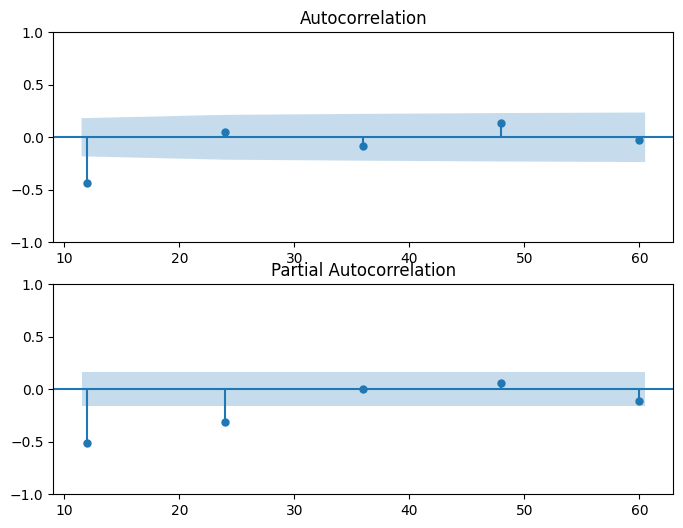

In [45]:
# Make list of lags
lags = [12, 24, 36, 48, 60]

# Create the figure 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

## Plot the ACF on ax1
plot_acf(aus_employment_diff, lags=lags, ax=ax1, zero=False)

# Plot the PACF on ax2
plot_pacf(aus_employment_diff, lags=lags, ax=ax2, zero=False)
plt.show()

Based on the ACF and PACF plots, these models is most likely for the data: $\text{SARIMA}(0,1,0)(0,1,1)_{12}$


The non-seasonal ACF doesn't show any of the usual patterns of MA, AR or ARMA models so we choose none of these. The Seasonal ACF and PACF look like an MA(1) model. We select the model that combines both of these.


In this exercise, we will see the effect of using a SARIMA model instead of an ARIMA model on our forecasts of seasonal time series.

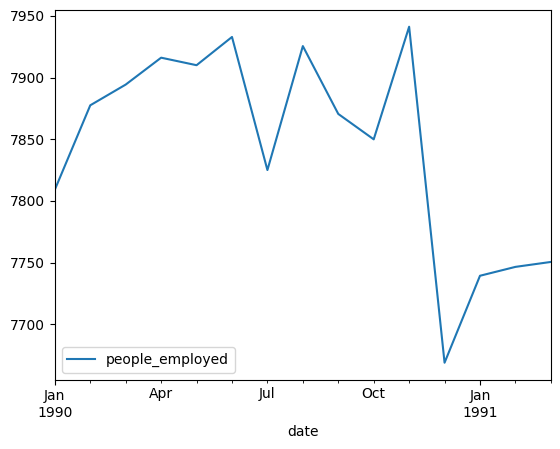

15


In [46]:
aus_employment_train = aus_employment[:'1990'].copy()
aus_employment_test = aus_employment['1990':].copy()

aus_employment_test.plot()
plt.show()
print(len(aus_employment_test))

In [47]:
arima_results = ARIMA(aus_employment_train, order=(3,1,0)).fit()
sarima_results = SARIMAX(aus_employment_train, order=(0,1,0), seasonal_order=(0,1,1,12)).fit()

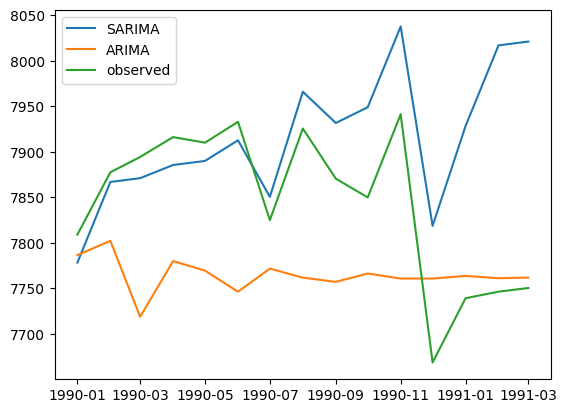

In [48]:
# Create ARIMA mean forecast
arima_pred = arima_results.get_forecast(steps=15)
arima_mean = arima_pred.predicted_mean

# Create SARIMA mean forecast
sarima_pred = sarima_results.get_forecast(steps=15)
sarima_mean = sarima_pred.predicted_mean

# Plot mean ARIMA and SARIMA predictions and observed
plt.plot(aus_employment_test.index, sarima_mean, label='SARIMA')
plt.plot(aus_employment_test.index, arima_mean, label='ARIMA')
plt.plot(aus_employment_test, label='observed')
plt.legend()
plt.show()

We can see that the SARIMA model has forecast the upward trend and the seasonal cycle, whilst the ARIMA model has only forecast the "DC". This makes the SARIMA forecast much closer to the truth for this seasonal data!

#### Automation and saving

The `pmdarima` package is a powerful tool to help us choose the model orders. We can use the information we already have from the identification step to narrow down the model orders which we choose by automation.

#### Saving and updating models

Once we have gone through the steps of the Box-Jenkins method and arrived at a model we are happy with, we will want to be able to save that model and also to incorporate new measurements when they are available. This is key part of putting the model into production.

```
# Import joblib
Import joblib

# Set model name
filename = "candy_model.pkl"

# Pickle it
joblib.dump(model,filename)


# Load the model back in
loaded_model = joblib.load(filename)

# Update the model
loaded_model.update(df_new)

```

The last step updates an old model with new measurements. This means it will make better prediction of the future. The next step might be to make new predictions with this model or save the updated version back to the file.

#### SARIMA and Box-Jenkins

Usually the next step would be to find the order of differencing and other model orders. However, this time it's already been done for us. The time series is best fit by a $\text{SARIMA}(1,1,1)(0,1,1)_{12}$ model with an added constant.

In this exercise we will make sure that this is a good model by first fitting it using the `SARIMAX` class and going through the normal model diagnostics procedure.

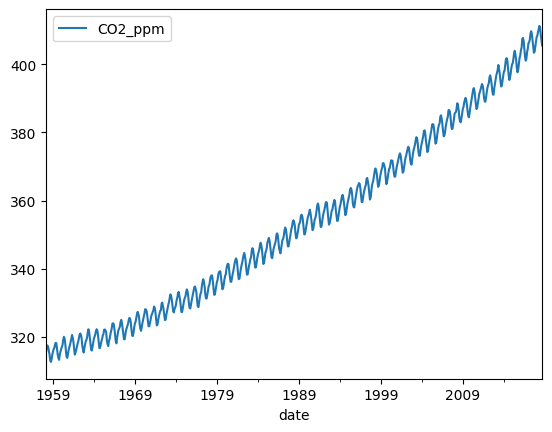

In [50]:
co2 = pd.read_csv('data_3/co2.csv', 
                  index_col='date',
                  parse_dates=True)

co2 = co2.asfreq(freq = 'MS')

co2.plot()
plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                            CO2_ppm   No. Observations:                  727
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -183.113
Date:                            Mon, 22 May 2023   AIC                            374.226
Time:                                    14:46:26   BIC                            392.510
Sample:                                03-01-1958   HQIC                           381.287
                                     - 09-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1959      0.081      2.409      0.016       0.037       0.355
ma.L1         -0.5609      0.070   

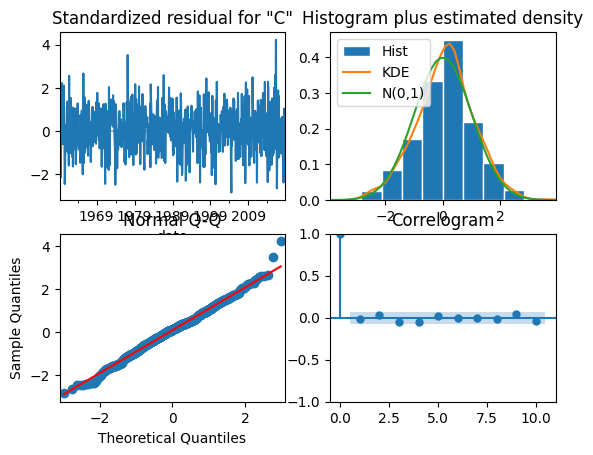

In [52]:
# Create model object
model = SARIMAX(co2, 
                order=(1,1,1), 
                seasonal_order=(0,1,1,12), 
)
# Fit model
results = model.fit()

print(results.summary())


# Plot common diagnostics
results.plot_diagnostics()
plt.show()

Based on Prob(Q) and Prob(JB) + diagnostic plots, we can say that residuals are not correlated and they are normally distributed.

In the previous exercise we confirmed that a $\text{SARIMA}(1,1,1)(0,1,1)_{12}$ model was a good fit to the CO2 time series by using diagnostic checking.

Now its time to put this model into practice to make future forecasts. Climate scientists tell us that we have until 2030 to drastically reduce our CO2 emissions or we will face major societal challenges.

In this exercise, we will forecast the CO2 time series up to the year 2030 to find the CO2 levels if we continue emitting as usual.

In [53]:
# Create forecast object
forecast_object = results.get_forecast(steps=136 )

# Extract predicted mean attribute
mean = forecast_object.predicted_mean

# Calculate the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index

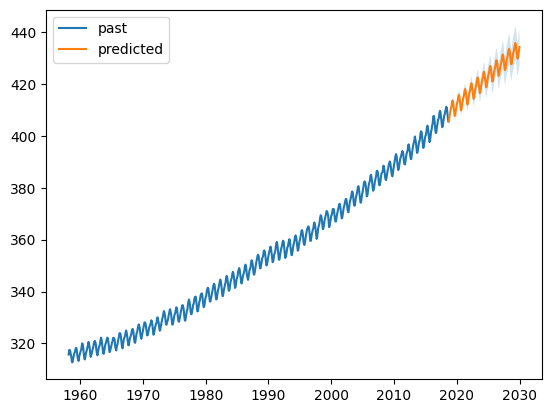

In [54]:
plt.figure()

# Plot past CO2 levels
plt.plot(co2.index, co2, label='past')

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.loc[:,'lower CO2_ppm'], conf_int.loc[:,'upper CO2_ppm'], alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.show()

In [55]:
# Print last predicted mean
print(mean.iloc[-1])

# Print last confidence interval
print(conf_int.iloc[-1])

434.2605258279802
lower CO2_ppm    427.484722
upper CO2_ppm    441.036330
Name: 2030-01-01 00:00:00, dtype: float64


Our estimate says that CO2 will increase by roughly another 35ppm from October 2018 to January 2030. What do you think would happen if we lowered or raised our emission rates between now an then? How would our model perform if these dynamics changed?